In [60]:
import pandas as pd 
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [61]:
"""
file = "C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/"
file_name = 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv'
df = pd.read_csv(file+file_name)
df
"""

'\nfile = "C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/"\nfile_name = \'teeth_break_H_torque_circulation_2000rpm_10Nm.csv\'\ndf = pd.read_csv(file+file_name)\ndf\n'

In [62]:
file = "C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/"
file_name = 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv'

## 1. Funções para extrair dados a partir do nome do dataset

In [63]:
def extract_info_from_filename(filename,fault): # "health" , "geral", "miss_teeth"
    if fault == "geral":
        pattern2 = r"^(.*)_(L|M|H)_(torque_circulation)_(\d+rpm|rpm\d+)_(\d+Nm)\.csv$" 
        match = re.match(pattern2, filename)
        if match:
            return {
                "Fault": match.group(1),
                "Degree": match.group(2),
                "Categoria": match.group(3),
                "Torque": match.group(5),
                "Rotação": match.group(4)
            }
        return {}
    
    if fault == "health":
        pattern2 = r"^(.*)_(torque_circulation)_(\d+rpm|rpm\d+)_(\d+Nm)\.csv$" #essa ordem so funciona se vier torque primeiro (speed circulation)
        match = re.match(pattern2, filename)
        if match:
            return {
                "Fault": match.group(1),
                "Categoria": match.group(2),
                "Torque": match.group(4), 
                "Rotação": match.group(3)
            }
        return {}

    if fault == "miss_teeth":
        pattern2 = r"^(.*)_(torque_circulation)_(\d+rpm|rpm\d+)_(\d+Nm)\.csv$" #essa ordem so funciona se vier torque primeiro (speed circulation)
        match = re.match(pattern2, filename)
        if match:
            return {
                "Fault": match.group(1),
                "Categoria": match.group(2),
                "Torque": match.group(4), 
                "Rotação": match.group(3)
            }
        return {}

### 1.4 Adicação da coluna time_index e time

In [64]:
def extract_and_format_dataframe(file,file_name,falha): #falha = "geral", "miss_teeth", "health"

    df = pd.read_csv(file+file_name)
    info = extract_info_from_filename(file_name,falha)
    
    for col, value in info.items():
        df[col] = value

    #Organização das colunas
    df.drop(columns=['Categoria','speed','motor_vibration_x','motor_vibration_y','motor_vibration_z'],inplace=True)
    df.rename(columns={'torque':'Input Torque',"Torque":"Output Torque"},inplace=True)

    #Adição do tempo
    df['time_index'] =df.index
    df['time'] = df['time_index']/12800
    return df



## 1.5 Fórmula 1.4 para basona

In [65]:
def format_dataframe_basona(df): #falha = "geral", "miss_teeth", "health"
    #Organização das colunas
    df.drop(columns=['Categoria','speed','motor_vibration_x','motor_vibration_y','motor_vibration_z'],inplace=True)
    df.rename(columns={'torque':'Input Torque',"Torque":"Output Torque"},inplace=True)

    #Adição do tempo
    df['time_index'] =df.index
    df['time'] = df['time_index']/12800
    return df



## 2. Filtragem do intervalo de tempo

In [66]:
def format_time(dataframe,intervalo): #timeframe = "inicial" , "final", "total"
    df_1 = dataframe
    df_2 = dataframe
    df_1.loc[df_1.time <= 19, 'adj_time'] = df_1.time - 11
    df_2.loc[((df_2.time <= 49) & (df_2.time >41)), 'adj_time'] = df_1.time - 33
    
    df_1 = df_1[(df_1['time']>=11) & (df_1['time']<=19)]
    df_2 = df_2[(df_2['time']>41) & (df_2['time']<=49)]
    df3 = pd.concat([df_1,df_2],ignore_index=True)

    if intervalo == "inicial":
        return df_1
    if intervalo == "final":
        return df_2
    if intervalo =="total":
        return df3

## 3. Funções Para a extração de Features

In [67]:
from time_domain_statistics import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value

### 3.1 Criação do Dataframe de Features

In [68]:
def features_extract(Dataframe):
    target_columns = Dataframe[['Input Torque','gearbox_vibration_x','gearbox_vibration_y','gearbox_vibration_z']]
    stats_func = {"rms":rms,"pk_pk":pk_pk,"kurtosis":kurtosis, "crest_factor":crest_factor,
                "skewness":skewness, "shape_factor":shape_factor,"mean":mean_value,
                "std":std_value,"min":min_value,"max":max_value}
    features ={}

    for col_name in target_columns: # ok estou aplicando os nomes das colunas nas keys do dicionario
        #quero fazer primeira variável e depois os 9 statistics dessa variiável 
        for nome,func in stats_func.items(): #para cada nome da função e função
        
            features[f'{col_name}.{nome}'] = func(Dataframe[col_name]) #printar a variável, nome da função e aplicar a função no resultado
            # tudo isso sendo salvo no dicionário {features}
    New_Dataframe= pd.DataFrame([features],index=[0])

    #features.items()
    return New_Dataframe

### 3.2 Funções para splitar em time frames o dataset de Features 

In [69]:
def features_timeframe(df_feature,timeframe): #timeframe = 0.1 ; 0.2 ; 0.5 ; 1s
    time_interval = timeframe  # 0.1 second
    data = df_feature
    # Create an empty DataFrame to store the features
    features_df = pd.DataFrame()

    # Determine the starting and ending times for each segment
    start_time = data['adj_time'].min()
    end_time = data['adj_time'].max()
    index = []
    # ok - básico #

    # Iterate over each time segment
    current_time = start_time
    while current_time + time_interval <= end_time:
        # Select the data for the current second
        mask = (data['adj_time'] >= current_time) & (data['adj_time'] < current_time + time_interval) #arquivar o intervalo desejado na variável
        df_second = data.loc[mask]  # filtrar o invervalo desejado no dataframe
        
        # Calculate features if the slice has data          ## Aqui calcula o que quiser no intervalo
        if not df_second.empty:                             ## essa parte do código que vou modificar e colocar oq quero
            current_features_df = features_extract(df_second)
            index.append(current_time + time_interval)


            features_df = pd.concat([features_df, current_features_df])
        
        # Move to the next time interval
        current_time += time_interval      #armazenar o novo tempo para iterar
        features_df.index.name = 'time_frame_end'
    # Output the resulting DataFrame with the features for each second
    features_df.index = index
    features_df.index.name = 'time_frame_end'

    return features_df

## 0.Funções  de visualização de gráficos 

### 0.1 Função para plotar visualizações dataset original

In [70]:
def plot_df(dataframe,x_axis):        # ex: plot_df (df,'adj_time')
    data = dataframe

    fig, ax = plt.subplots(2,2,figsize=(30,10))

    selected_columns = data.columns[0:4]     # ajustar aqui quais colunas quer plotar
    for i,column in enumerate(selected_columns):   
        sns.lineplot(data=data,x=data[x_axis], y=column,ax=ax.ravel()[i])

    return plt.show()

### 0.2 Função para plotar visualizações dataset de features

In [71]:
def plot_df_features(dataframe,x_axis,variavel):        # ex: plot_df (df,df.index,'Input Torque')
    data = dataframe
    intervalo = {"Input Torque":slice(0,10),"gearbox_vibration_x":slice(10,20),"gearbox_vibration_y":slice(20,30),"gearbox_vibration_z":slice(30,40)}

    # para caso de querer plotar o index como x_axis  --> chamar a função plot_df(df,df.index)
    if x_axis is dataframe.index:
        data['index'] = dataframe.index
        x_axis = 'index'

    fig, ax = plt.subplots(5,2,figsize=(30,20))

    selected_columns = data.columns[intervalo[variavel]]     # ajustar aqui quais colunas quer plotar
    for i,column in enumerate(selected_columns):   
        sns.lineplot(data=data,x=data[x_axis], y=column,ax=ax.ravel()[i])

#    return plt.show()

### 0.3 Função para comparar datasets

In [72]:
def compare_df_plots(df1, df2, variavel):
    intervalo = {"Input Torque": slice(0, 10), "gearbox_vibration_x": slice(10, 20),
                 "gearbox_vibration_y": slice(20, 30), "gearbox_vibration_z": slice(30, 40)}
    
    fig, ax = plt.subplots(5, 2, figsize=(30, 20))  # Create the subplot structure outside
    selected_columns = df1.columns[intervalo[variavel]]

    for i, column in enumerate(selected_columns):
        # For df1
        sns.lineplot(data=df1, x=df1.index, y=column, ax=ax.ravel()[i], color='blue', label=f"{'df1'}:{column}")
        # For df2
        sns.lineplot(data=df2, x=df2.index, y=column, ax=ax.ravel()[i], color='red', label=f"{'df2'}:{column}")
        ax.ravel()[i].legend()

    plt.show()

# Execução : testagem

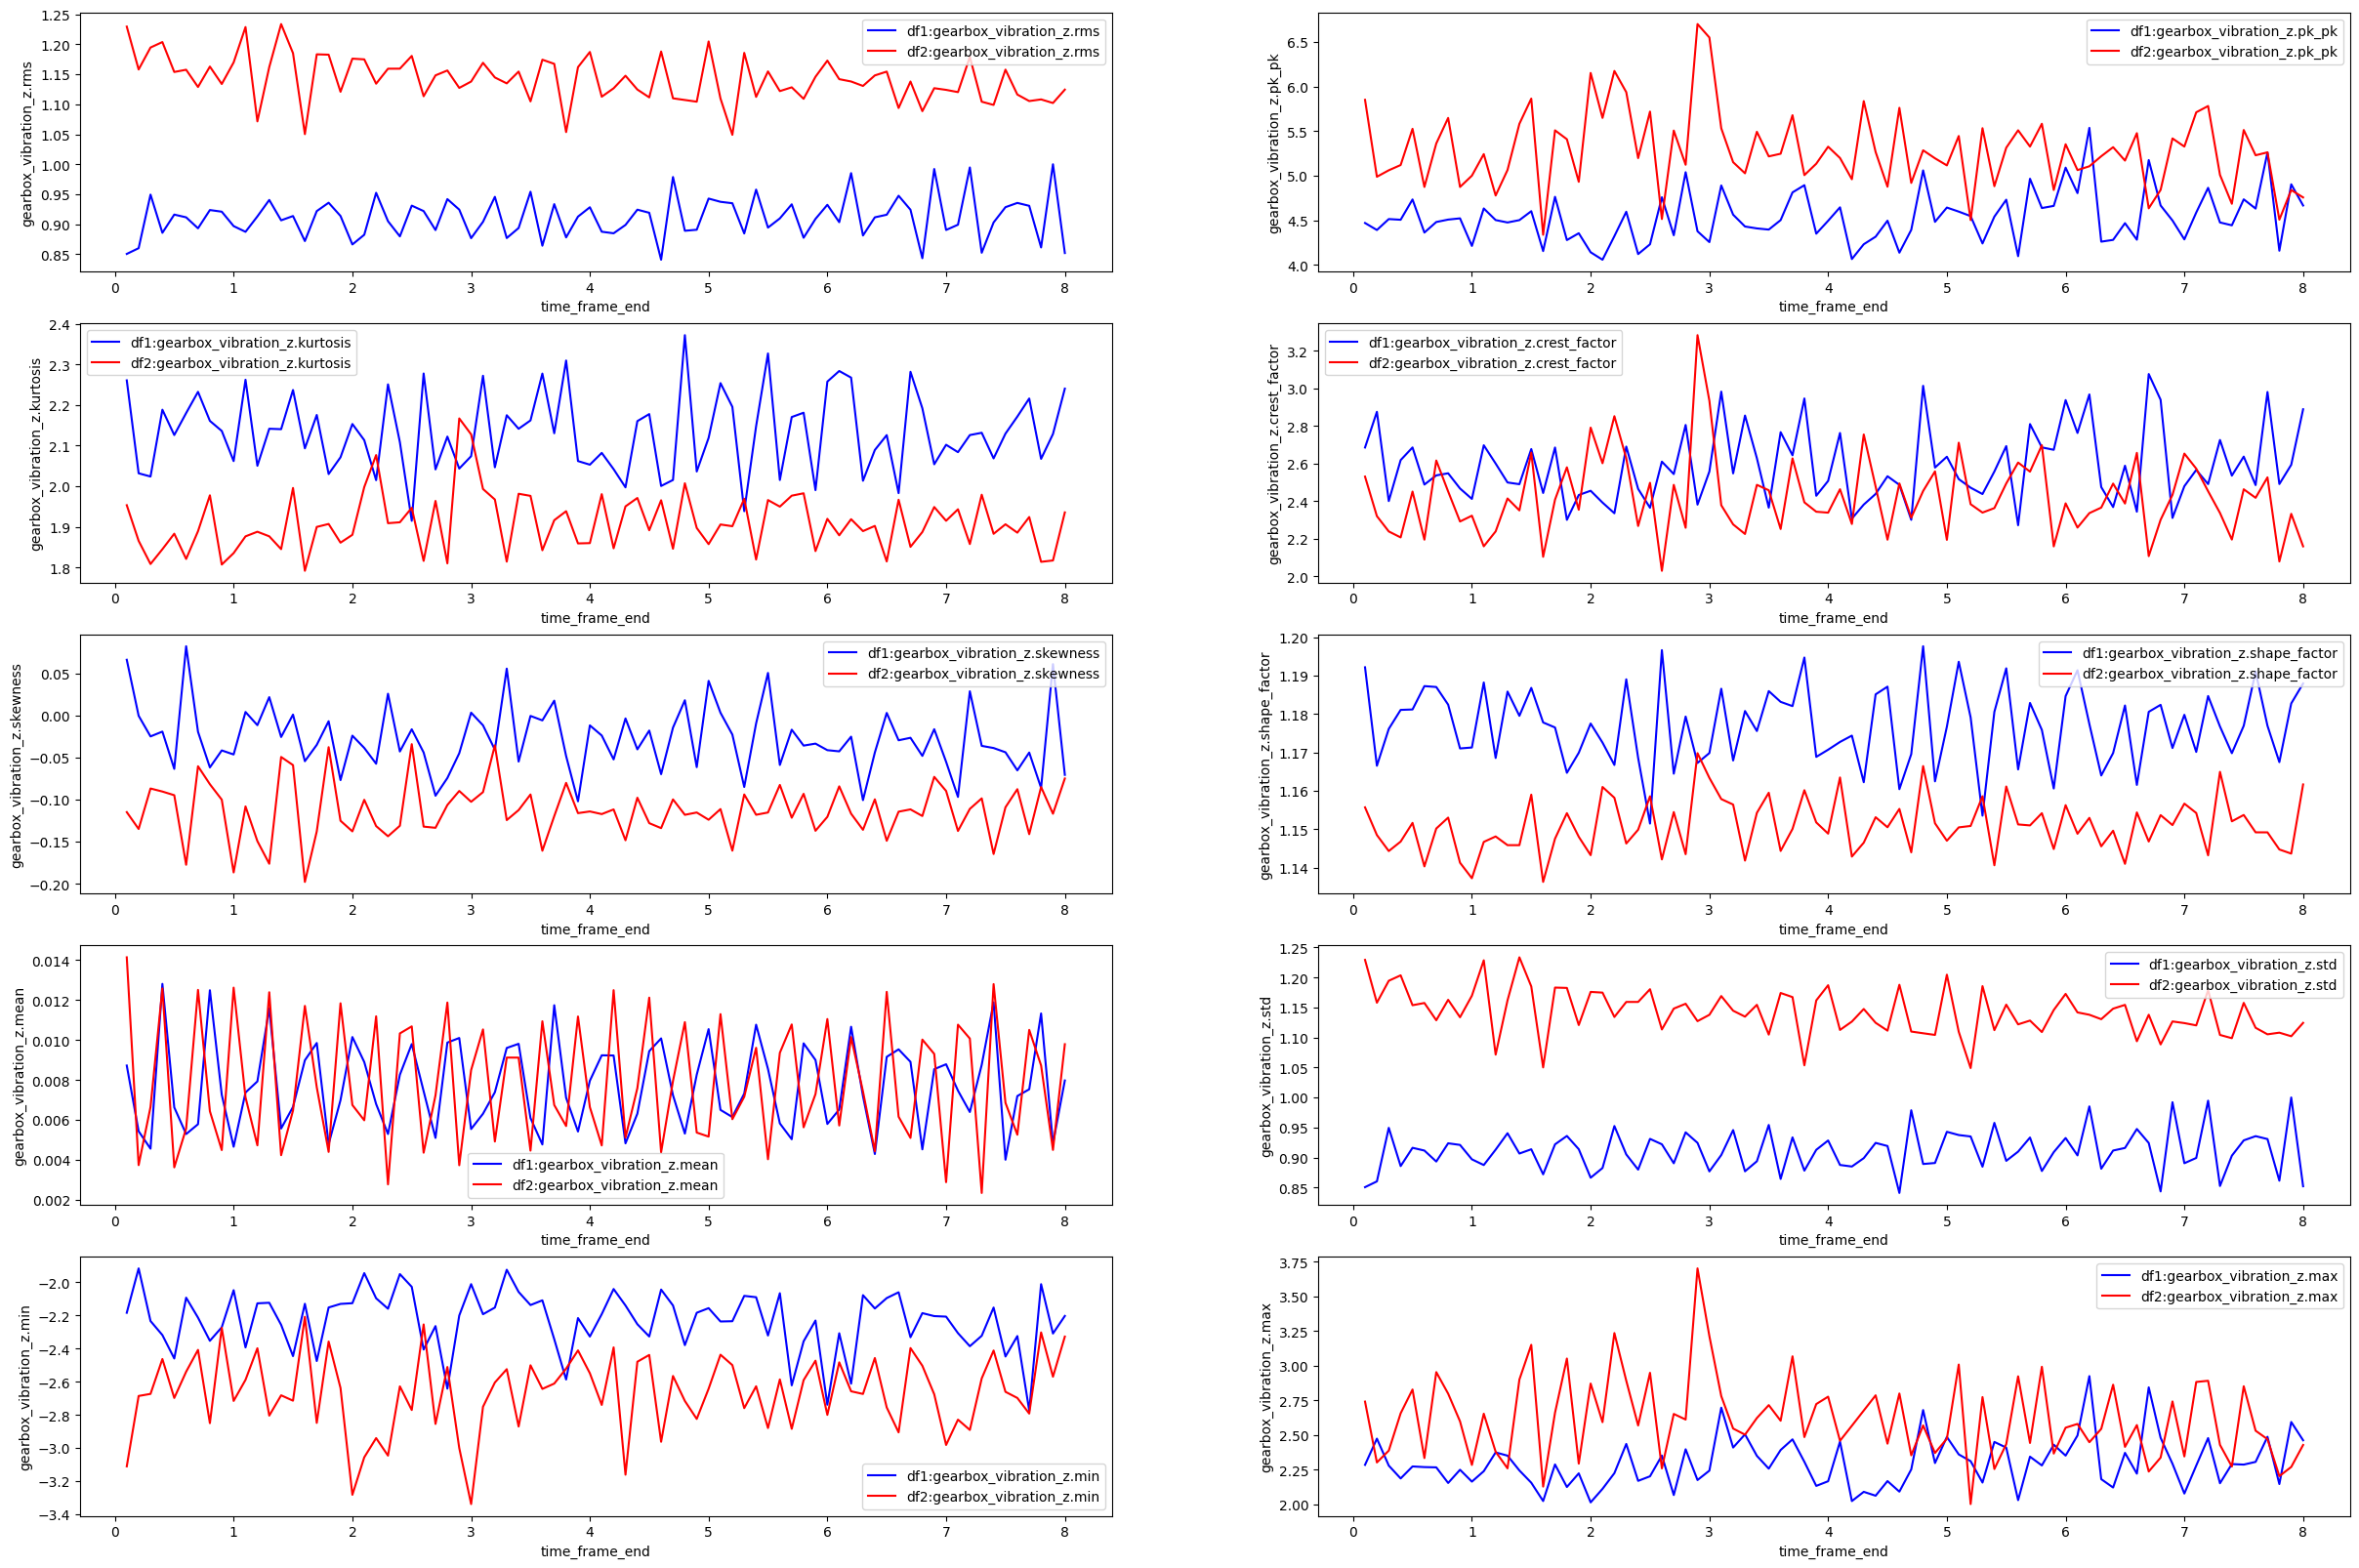

In [73]:
df1 = extract_and_format_dataframe("C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/",
                                  'teeth_break_H_torque_circulation_2000rpm_10Nm.csv',
                                  "geral")

#df1_name = extract_info_from_filename_torque('teeth_break_H_torque_circulation_2000rpm_10Nm.csv')
#df1_name = (f"{df1_name['Fault']}_{df1_name['Degree']}_{df1_name['Torque']}")

df2 = extract_and_format_dataframe("C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/",
                                  'health_torque_circulation_2000rpm_10Nm.csv',
                                  "health")

#df2_name = extract_info_from_filename_health_torque('health_torque_circulation_2000rpm_10Nm.csv')
#df2_name = (f"{df2_name['Fault']}_{df2_name['Torque']}")

df1 = format_time(df1,'inicial')
df2 = format_time(df2,'inicial')

df1_ft = features_timeframe(df1,0.1)
df2_ft = features_timeframe(df2,0.1)

compare_df_plots(df1_ft,df2_ft,'gearbox_vibration_z')

# 4.1 subFunção para criar basona

In [74]:
def extract_datasets_and_process_features(data_dir,fault,intervalo,timeframe): #aqui defino no input qual o diretório de data (pasta) e qual função vou usar 
    combined_dataframes = []
    combined_datafiles = []
    # Para cada arquivo CSV no diretório
    for filename in os.listdir(data_dir):
        if filename.endswith(".csv"):
            filepath = os.path.join(data_dir, filename)

            # Carregando o dataset
            df = pd.read_csv(filepath)

            # Extraindo informações do nome do arquivo e adicionando como novas colunas
            info = extract_info_from_filename(filename,fault) ## utilizar a função adequada a cada nome de base ## 
            for col, value in info.items():
                df[col] = value
#Operações tratamento features         
            #Chamada Função 1.5 
            df= format_dataframe_basona(df)
            #Até aqui o number of files é um valor válido
            
            #Chamada Função 2.0
            df = format_time(df,intervalo) #filtragem do tempo
            #Chamada Função 3.0
            #df = features_extract(df)      #### Usarei essa para criar as regras do meu Sistema Especialista (SE) ####
            #Aqui temos a tabela com as features médias do intervalo (Meu SE)

            #Chamada função 3.2
            df = features_timeframe(df,timeframe) ###### Escolher tamanho timeframe (número de linhas)########

            #adicionando novamente o nome do arquivo
            for col, value in info.items():
                df[col] = value

            # Adicionando ao conjunto de dataframes combinados
            #col = "Fault"       # fui obrigado a atribuir um valor pra col, pq ele n tava lendo na hr de passar a função miss_teeth_torque, por algum motivo que n sei; teoricamente isso n muda nada no código, só deixa ele um pouco menos genérico, mas como todos meus datasets vão ter a coluna 'Fault' não será problema
            if "Fault" in df.columns:
                if df["Fault"].notna().any():
                    combined_dataframes.append(df)
                    combined_datafiles.append(filename)
    else:
        print(f"Columns [col] not found in [filename]")    #essa parte da formula me permite ler pastas com ambos arquivos speed e torque e só pegar o válido e ignorar os demais
            
    # Combinando todos os dataframes em um único DataFrame final
    #final_df = pd.concat(combined_dataframes, ignore_index=True)
    if combined_dataframes:
        final_df = pd.concat(combined_dataframes, ignore_index=True)
    else:
        final_df = pd.DataFrame()  # Empty DataFrame if no data available

    return final_df, combined_datafiles

# Processando e combinando os datasets
#combined_dataset, file_names = process_and_combine_datasets(teste_data_dir,extract_info_from_filename_speed)

## 

## 4.2 Função para ler ler datasets de 1 pasta 
- Health ou Geral ou miss_teeth

In [75]:
# Função geral de combinação dos arquivos features por falha
diretorio = "C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/Treino/"

def read_1file_datasets(diretorio,fault):
    dir = (f'{diretorio+fault}/')
    combined_dataset, file_names = extract_datasets_and_process_features(dir,fault,"inicial",1)
    print(f'number of files = {len(file_names)}')
    print(f'combined files : {file_names}')
    return combined_dataset
read_1file_datasets(diretorio,"miss_teeth")

Columns [col] not found in [filename]
number of files = 1
combined files : ['miss_teeth_torque_circulation_2000rpm_20Nm.csv']


,Input Torque.rms,Input Torque.pk_pk,Input Torque.kurtosis,Input Torque.crest_factor,Input Torque.skewness,Input Torque.shape_factor,Input Torque.mean,Input Torque.std,Input Torque.min,Input Torque.max,...,gearbox_vibration_z.skewness,gearbox_vibration_z.shape_factor,gearbox_vibration_z.mean,gearbox_vibration_z.std,gearbox_vibration_z.min,gearbox_vibration_z.max,Fault,Categoria,Torque,Rotação
0,3.421446,0.423413,4.223364,1.069639,0.700416,1.000089,3.421141,0.045642,3.236300,3.659713,...,-0.186983,1.198534,0.007094,1.239568,-5.499017,3.983080,miss_teeth,torque_circulation,20Nm,2000rpm
1,3.451727,0.412488,4.846562,1.077731,0.962850,1.000099,3.451384,0.048670,3.307545,3.720033,...,-0.197346,1.207924,0.008276,1.244246,-5.482650,4.705119,miss_teeth,torque_circulation,20Nm,2000rpm
2,3.460998,0.383788,5.710111,1.068069,1.166187,1.000092,3.460680,0.046906,3.312796,3.696585,...,-0.218918,1.207099,0.007199,1.231101,-5.368352,4.319120,miss_teeth,torque_circulation,20Nm,2000rpm
3,3.459745,0.332665,4.159950,1.055826,0.754438,1.000084,3.459453,0.044906,3.320223,3.652889,...,-0.200700,1.202634,0.007538,1.228126,-5.093157,4.215455,miss_teeth,torque_circulation,20Nm,2000rpm
4,3.461587,0.397658,5.575800,1.074883,1.224163,1.000106,3.461220,0.050407,3.323144,3.720802,...,-0.214493,1.206080,0.008112,1.222735,-5.209756,4.233468,miss_teeth,torque_circulation,20Nm,2000rpm
5,3.467926,0.365168,4.424127,1.066955,0.811066,1.000081,3.467644,0.044260,3.334951,3.700119,...,-0.208275,1.208577,0.007685,1.218091,-5.266523,4.385209,miss_teeth,torque_circulation,20Nm,2000rpm
6,3.469503,0.406027,5.086653,1.076949,1.084990,1.000105,3.469139,0.050230,3.330451,3.736478,...,-0.206776,1.204486,0.007145,1.210744,-4.583931,4.024839,miss_teeth,torque_circulation,20Nm,2000rpm
7,3.465401,0.357354,4.838398,1.064958,0.876203,1.000076,3.465139,0.042584,3.333151,3.690505,...,-0.216912,1.205354,0.007733,1.212587,-5.422366,4.534554,miss_teeth,torque_circulation,20Nm,2000rpm


## 4.3 Função concatenar datasets features todos

In [76]:
# Função geral de combinação dos arquivos features


def combine_features_datasets(file,intervalo,timeframe): #('treino','inicial','0.1') file = "treino","todos","teste"
    diretorio = "C:/Users/tiago/OneDrive/Desktop/TCC/Dados/split-dataset-2000rpm/"

    dir_geral = (f'{diretorio}{file}/geral/')
    combined_dataset_geral, file_names_geral = extract_datasets_and_process_features(dir_geral,"geral",intervalo,timeframe)
    print(f'number of files geral = {len(file_names_geral)}')
    print(f'combined files geral: {file_names_geral}')
    
    dir_health = (f'{diretorio}{file}/health/')
    combined_dataset_health, file_names_health = extract_datasets_and_process_features(dir_health,"health",intervalo,timeframe)
    print(f'number of files health = {len(file_names_health)}')
    print(f'combined files health: {file_names_health}')
    
    dir_misst = (f'{diretorio}{file}/miss_teeth/')
    combined_dataset_misst, file_names_misst = extract_datasets_and_process_features(dir_misst,"miss_teeth",intervalo,timeframe)
    print(f'number of files miss_teeth = {len(file_names_misst)}')
    print(f'combined files miss_teeth: {file_names_misst}')
    
    comb_datasets = [combined_dataset_geral,combined_dataset_health,combined_dataset_misst]
    df_concat = pd.concat(comb_datasets, ignore_index=True)
    return df_concat

In [77]:
df_features = combine_features_datasets("treino","inicial",1)

Columns [col] not found in [filename]
number of files geral = 15
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_crack_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_crack_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_crack_M_torque_circulation_2000rpm_10Nm.csv']
Columns [col] not found in [filename]
number of files health = 2
combined files health: ['health_torque_circulation_2000r

In [79]:
df_features = combine_features_datasets("treino","inicial",0.5)
df_features

Columns [col] not found in [filename]
number of files geral = 15
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_crack_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_crack_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_crack_M_torque_circulation_2000rpm_10Nm.csv']
Columns [col] not found in [filename]
number of files health = 2
combined files health: ['health_torque_circulation_2000r

,Input Torque.rms,Input Torque.pk_pk,Input Torque.kurtosis,Input Torque.crest_factor,Input Torque.skewness,Input Torque.shape_factor,Input Torque.mean,Input Torque.std,Input Torque.min,Input Torque.max,...,gearbox_vibration_z.shape_factor,gearbox_vibration_z.mean,gearbox_vibration_z.std,gearbox_vibration_z.min,gearbox_vibration_z.max,Fault,Degree,Categoria,Torque,Rotação
0,1.419724,0.259167,3.682095,1.073651,0.506101,1.000310,-1.419283,0.035362,-1.524287,-1.265121,...,1.177487,0.007988,0.930853,-2.676105,2.344239,gear_pitting,H,torque_circulation,10Nm,2000rpm
1,1.426541,0.318521,4.943065,1.084866,1.008513,1.000405,-1.425963,0.040593,-1.547605,-1.229084,...,1.171539,0.007414,0.930125,-2.754283,2.158773,gear_pitting,H,torque_circulation,10Nm,2000rpm
2,1.430232,0.325996,4.502439,1.082866,0.965257,1.000455,-1.429581,0.043135,-1.548749,-1.222754,...,1.174692,0.007206,0.931448,-2.647686,2.227604,gear_pitting,H,torque_circulation,10Nm,2000rpm
3,1.438550,0.354439,5.886604,1.083582,1.281820,1.000444,-1.437911,0.042871,-1.558787,-1.204348,...,1.172359,0.007598,0.932034,-2.532363,2.181852,gear_pitting,H,torque_circulation,10Nm,2000rpm
4,1.441517,0.348330,6.472291,1.084474,1.223042,1.000375,-1.440977,0.039447,-1.563287,-1.214957,...,1.172889,0.008422,0.944927,-2.504158,2.191210,gear_pitting,H,torque_circulation,10Nm,2000rpm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,3.467709,0.333303,4.162112,1.057832,0.831507,1.000088,3.467404,0.046013,3.334951,3.668255,...,1.206784,0.008625,1.217004,-4.648459,3.796363,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
284,3.470303,0.406027,4.966925,1.076701,1.011148,1.000108,3.469927,0.051090,3.330451,3.736478,...,1.202838,0.006947,1.204460,-4.583931,3.788745,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
285,3.468703,0.371408,5.215854,1.070640,1.163313,1.000101,3.468352,0.049342,3.342325,3.713733,...,1.206090,0.007343,1.216996,-4.410148,4.024839,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
286,3.468600,0.350916,5.136638,1.063975,0.973232,1.000077,3.468333,0.043068,3.339589,3.690505,...,1.210126,0.008714,1.216386,-5.240870,4.534554,miss_teeth,NaN,torque_circulation,20Nm,2000rpm


In [81]:
df_features_filt = df_features[['gearbox_vibration_x.shape_factor', 'gearbox_vibration_x.kurtosis',
       'gearbox_vibration_z.shape_factor', 'gearbox_vibration_z.kurtosis',
       'gearbox_vibration_x.std', 'gearbox_vibration_x.rms',
       'gearbox_vibration_z.rms', 'gearbox_vibration_z.std',
       'gearbox_vibration_x.crest_factor', 'gearbox_vibration_z.crest_factor','Fault','Degree', 'Categoria', 'Torque', 'Rotação']]
df_features_filt

,gearbox_vibration_x.shape_factor,gearbox_vibration_x.kurtosis,gearbox_vibration_z.shape_factor,gearbox_vibration_z.kurtosis,gearbox_vibration_x.std,gearbox_vibration_x.rms,gearbox_vibration_z.rms,gearbox_vibration_z.std,gearbox_vibration_x.crest_factor,gearbox_vibration_z.crest_factor,Fault,Degree,Categoria,Torque,Rotação
0,1.150065,1.894232,1.177487,2.145317,2.407102,2.407102,0.930887,0.930853,2.555294,2.874791,gear_pitting,H,torque_circulation,10Nm,2000rpm
1,1.143880,1.832740,1.171539,2.072547,2.408239,2.408240,0.930155,0.930125,2.497953,2.961103,gear_pitting,H,torque_circulation,10Nm,2000rpm
2,1.155218,1.939541,1.174692,2.123704,2.407825,2.407826,0.931476,0.931448,2.625359,2.842464,gear_pitting,H,torque_circulation,10Nm,2000rpm
3,1.141989,1.822384,1.172359,2.081464,2.384324,2.384324,0.932065,0.932034,2.408921,2.716938,gear_pitting,H,torque_circulation,10Nm,2000rpm
4,1.149944,1.865945,1.172889,2.081969,2.459971,2.459971,0.944965,0.944927,2.597999,2.650002,gear_pitting,H,torque_circulation,10Nm,2000rpm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,1.172002,2.208285,1.206784,2.549689,4.484649,4.484650,1.217035,1.217004,3.576983,3.819495,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
284,1.174183,2.259062,1.202838,2.569978,4.440735,4.440736,1.204480,1.204460,3.465884,3.805734,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
285,1.170141,2.230513,1.206090,2.604304,4.500949,4.500949,1.217018,1.216996,3.137676,3.623732,miss_teeth,NaN,torque_circulation,20Nm,2000rpm
286,1.171437,2.218351,1.210126,2.720341,4.449582,4.449583,1.216417,1.216386,3.215365,4.308448,miss_teeth,NaN,torque_circulation,20Nm,2000rpm


# Testes

Normalizando dados para comparar com gráfico eda 4

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Selecting numerical columns in the DataFrame
numerical_cols = df_features_filt.select_dtypes(include=['int64', 'float64']).columns
df_features_filt_n=df_features_filt.copy()
# Fitting the scaler and transforming the data
df_features_filt_n[numerical_cols] = scaler.fit_transform(df_features_filt[numerical_cols])

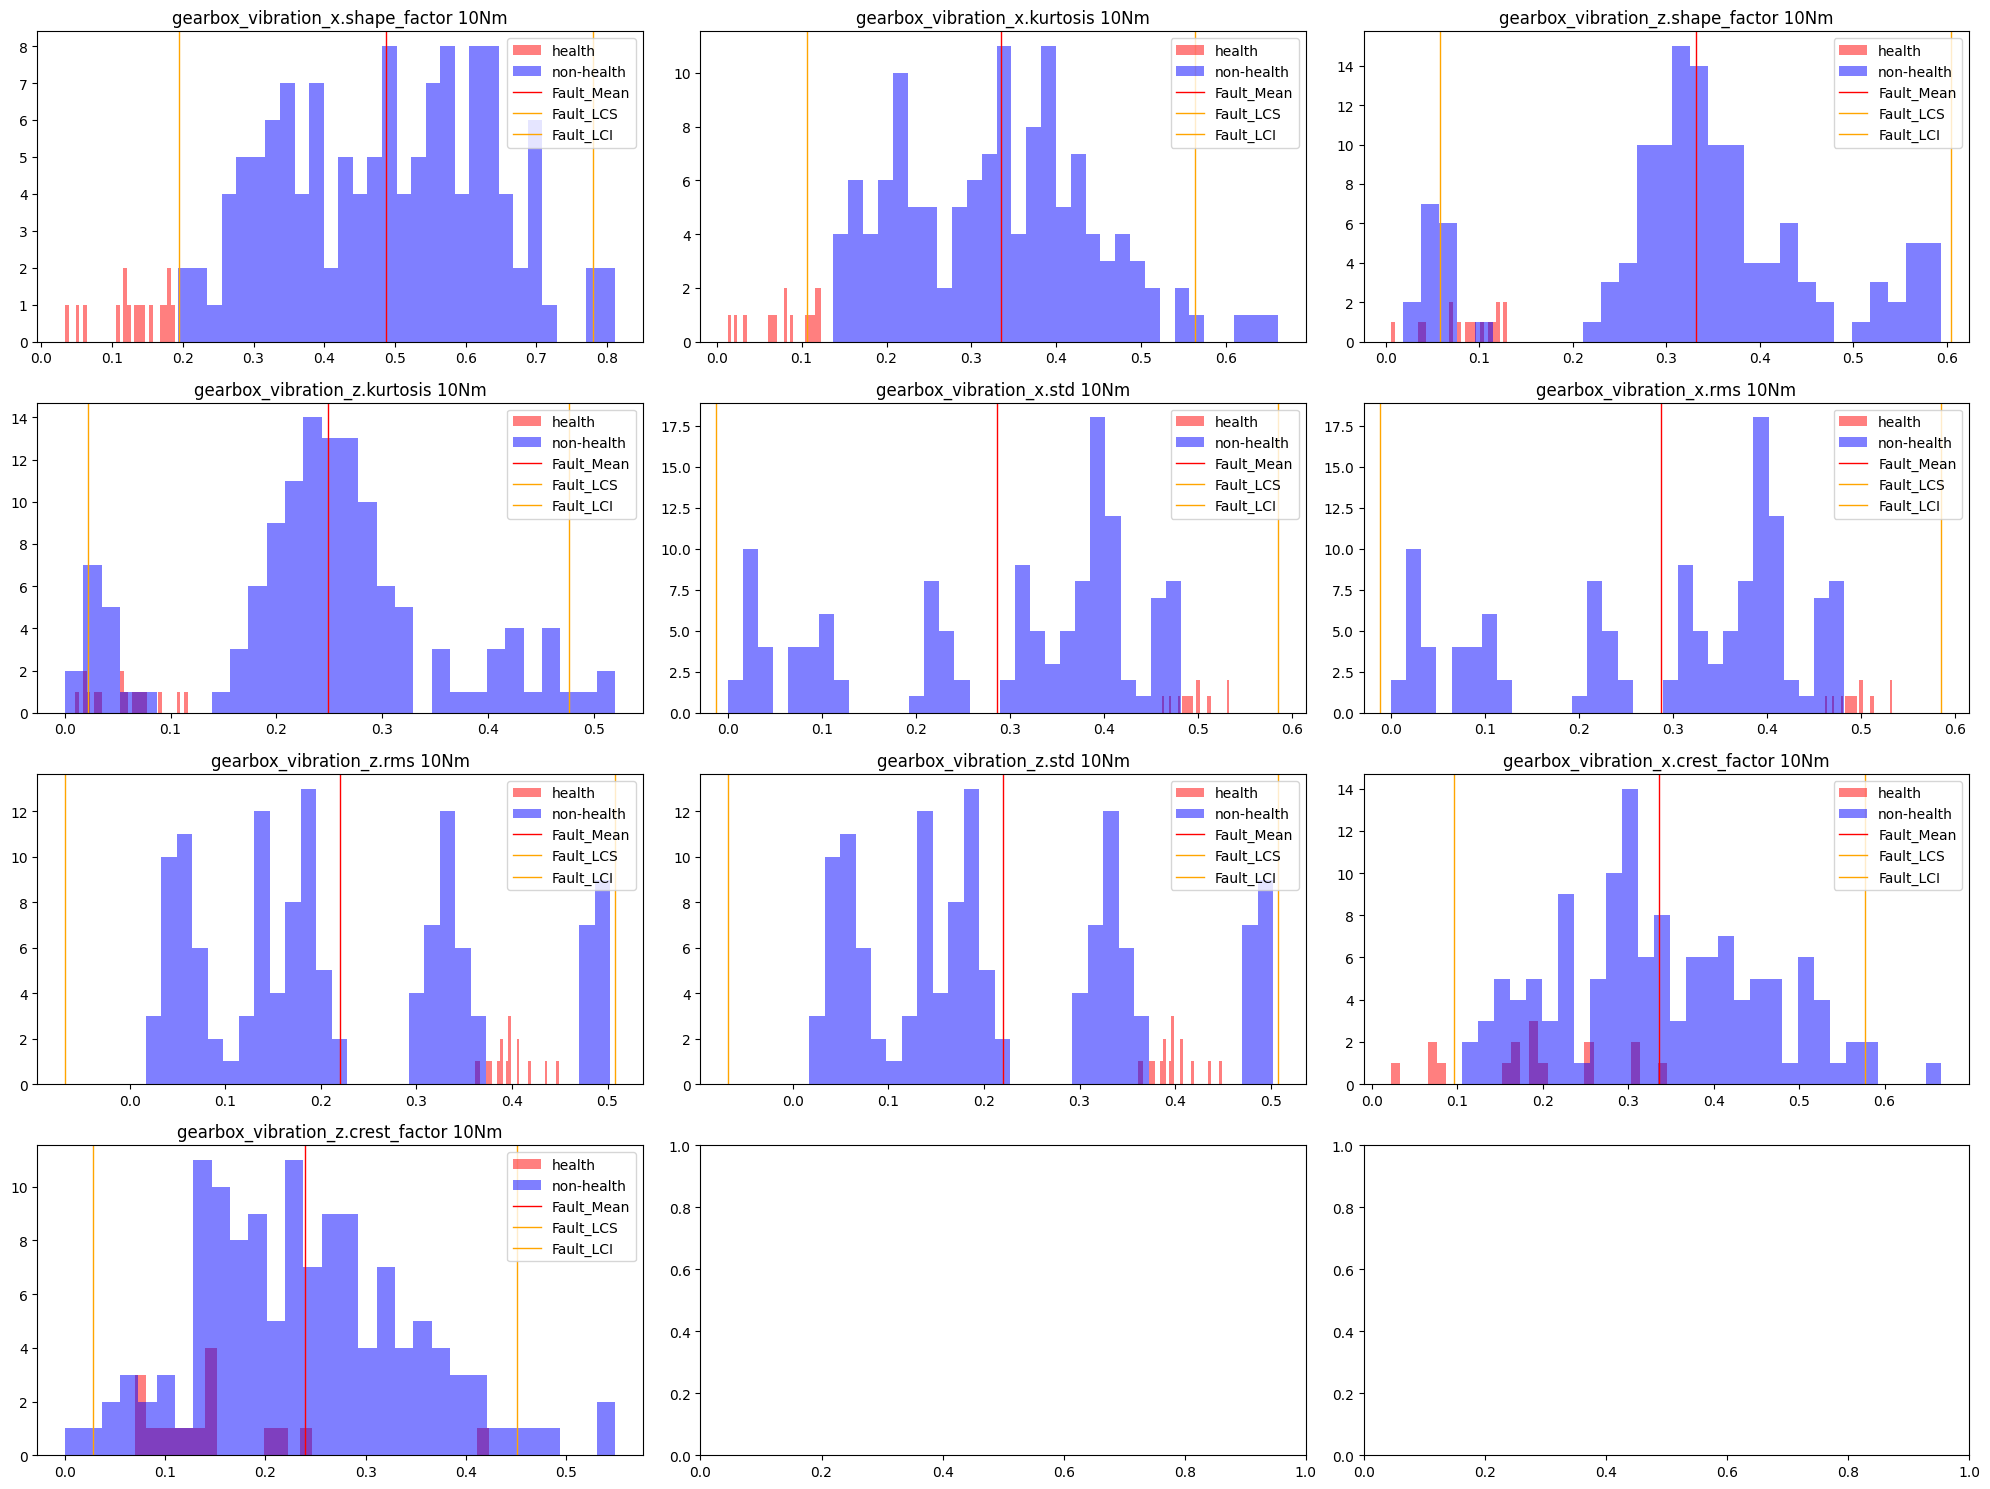

In [99]:
def plot_health_non_health_features(df_features,torque):
    # Example assumptions, uncomment or modify as needed
    df_features_torque = df_features[df_features['Torque'] == torque]
    #df_features_torque = df_features  # Use directly if no filtering by 'Torque'

    # Filter the data based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == "health"]
    non_health_data = df_features_torque[df_features_torque['Fault'] != "health"]

    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Degree', 'Categoria', 'Torque', 'Rotação'])

    # Determine the number of rows and columns for the subplots
    n_rows = 4
    n_cols = 3

    # Calculate the number of features and how many plots will be needed
    n_features = len(features)
    if n_features > n_rows * n_cols:
        raise ValueError("There are more features than available subplot slots; increase grid size or reduce features.")

    # Create subplots in a 4x3 grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot histograms for each feature in the grid
    for i, feature in enumerate(features):
        if i < n_rows * n_cols:  # Check to ensure there are no out-of-index errors
            bins = 30
            axs[i].hist(health_data[feature], bins, alpha=0.5, label='health', color='red')
            axs[i].hist(non_health_data[feature], bins, alpha=0.5, label='non-health', color='blue')

            # Calculate the mean and standard deviation for non_health_data
            mean_value = non_health_data[feature].mean()
            std_dev = non_health_data[feature].std()

            # Draw a red vertical line at the mean
            axs[i].axvline(mean_value, color='red', linestyle='solid', linewidth=1, label='Fault_Mean')
            
            # Draw yellow vertical lines at mean ± 3*std_dev
            axs[i].axvline(mean_value + 2 * std_dev, color='orange', linestyle='solid', linewidth=1, label='Fault_LCS')
            axs[i].axvline(mean_value - 2 * std_dev, color='orange', linestyle='solid', linewidth=1, label='Fault_LCI')

            axs[i].legend(loc='upper right')
            axs[i].set_title(feature+' '+torque)
        else:
            axs[i].axis('off')  # Turn off axes for any unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
plot_health_non_health_features(df_features_filt_n,"10Nm")
# Example usage:
# plot_health_non_health_features(your_dataframe)